In [56]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
from tqdm import tqdm
from skimage.data import imread
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D, AvgPool2D
from keras.layers import BatchNormalization
from keras.layers import Dense
from keras.layers import Flatten

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission_v2.csv', 'test_v2', 'train_ship_segmentations_v2.csv', 'train_v2']


In [57]:
train = pd.read_csv('../input/train_ship_segmentations_v2.csv')
train['path'] = '../input/train_v2/' + train['ImageId']
train.shape


(231723, 3)

In [58]:
train = train.sample(10000)
train.head()

,ImageId,EncodedPixels,path
207754,e5b114139.jpg,404325 1 405092 3 405859 4 406625 7 407392 7 4...,../input/train_v2/e5b114139.jpg
11428,0c6e369a2.jpg,396420 1 397187 3 397954 5 398721 7 399488 9 4...,../input/train_v2/0c6e369a2.jpg
158573,af0f9e7dd.jpg,NaN,../input/train_v2/af0f9e7dd.jpg
135838,95e83a655.jpg,NaN,../input/train_v2/95e83a655.jpg
173536,bfc219702.jpg,391628 1 392395 4 393163 6 393930 9 394698 11 ...,../input/train_v2/bfc219702.jpg


In [59]:
ships = train[~train.EncodedPixels.isna()].ImageId.unique()
noships = train[train.EncodedPixels.isna()].ImageId.unique()
ships

array(['e5b114139.jpg', '0c6e369a2.jpg', 'bfc219702.jpg', ...,
       '210f5d572.jpg', '49a89cbc5.jpg', 'fe35d8252.jpg'], dtype=object)

>### Add ShipExist Coloum

In [60]:
def ship_exist(encoded_pixels):
    hs = [0 if pd.isna(n) else 1 for n in tqdm(encoded_pixels)]
    return hs
train['ShipExist'] = ship_exist(train['EncodedPixels'].values)

100%|██████████| 10000/10000 [00:00<00:00, 907111.90it/s]


In [61]:
train.head()

,ImageId,EncodedPixels,path,ShipExist
207754,e5b114139.jpg,404325 1 405092 3 405859 4 406625 7 407392 7 4...,../input/train_v2/e5b114139.jpg,1
11428,0c6e369a2.jpg,396420 1 397187 3 397954 5 398721 7 399488 9 4...,../input/train_v2/0c6e369a2.jpg,1
158573,af0f9e7dd.jpg,NaN,../input/train_v2/af0f9e7dd.jpg,0
135838,95e83a655.jpg,NaN,../input/train_v2/95e83a655.jpg,0
173536,bfc219702.jpg,391628 1 392395 4 393163 6 393930 9 394698 11 ...,../input/train_v2/bfc219702.jpg,1


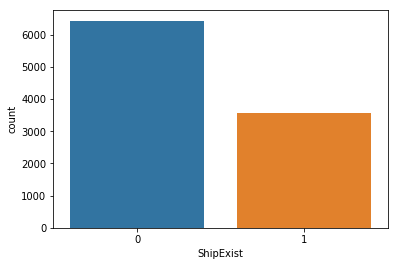

In [62]:
sns.countplot(train['ShipExist'])

In [63]:
train,test = train_test_split(train, test_size=0.3)

In [64]:
idg_train = ImageDataGenerator(rescale=1. / 255,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)

idg_test = ImageDataGenerator(rescale=1. / 255)

In [65]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [66]:
train_images = flow_from_dataframe(idg_train, train, 'path', 'ShipExist', batch_size=32, target_size=(256, 256))
test_images = flow_from_dataframe(idg_train, test, 'path', 'ShipExist', batch_size=32, target_size=(256, 256))

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 7000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3000 images


In [67]:
train_images.target_size

(256, 256)

CNN Structure

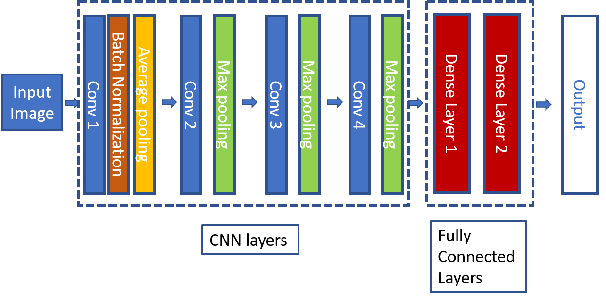

In [44]:
model = Sequential()

model.add(Convolution2D(32, (3, 3),
                       input_shape=(256, 256, 3),
                       strides = (1,1), 
                       padding = 'same',
                       kernel_initializer='he_normal',
                       activation='relu'))
model.add(BatchNormalization())
model.add(AvgPool2D(pool_size=(2, 2)))


model.add(Convolution2D(32, (3, 3),
                       input_shape=(256, 256, 3),
                       strides = (1,1), 
                       padding = 'same',
                       activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Convolution2D(32, (3, 3),
                       input_shape=(256, 256, 3),
                       strides = (1,1), 
                       padding = 'same',
                       activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Convolution2D(32, (3, 3),
                       input_shape=(256, 256, 3),
                       strides = (1,1), 
                       padding = 'same',
                       activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=128, activation='relu', kernel_initializer='normal'))
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='normal'))

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
average_pooling2d_1 (Average (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
__________

In [68]:
fitted_model = model.fit_generator(train_images,
                   steps_per_epoch=10000*(1-0.2)/32,
                   epochs=10,
                   validation_data=test_images,
                   validation_steps=10000*(0.2)/32)

Epoch 1/10
250/250 [==============================] - 1508s 6s/step - loss: 0.4694 - acc: 0.7821 - val_loss: 0.3894 - val_acc: 0.8189
Epoch 2/10
250/250 [==============================] - 1489s 6s/step - loss: 0.3692 - acc: 0.8529 - val_loss: 0.3825 - val_acc: 0.8456
Epoch 3/10
250/250 [==============================] - 1486s 6s/step - loss: 0.3180 - acc: 0.8761 - val_loss: 0.3815 - val_acc: 0.8611
Epoch 4/10
250/250 [==============================] - 1486s 6s/step - loss: 0.3003 - acc: 0.8838 - val_loss: 0.2959 - val_acc: 0.8859
Epoch 5/10
250/250 [==============================] - 1489s 6s/step - loss: 0.2668 - acc: 0.8995 - val_loss: 0.3096 - val_acc: 0.8790
Epoch 6/10
250/250 [==============================] - 1490s 6s/step - loss: 0.2536 - acc: 0.9019 - val_loss: 0.3153 - val_acc: 0.8949
Epoch 7/10
250/250 [==============================] - 1489s 6s/step - loss: 0.2308 - acc: 0.9127 - val_loss: 0.3128 - val_acc: 0.8854
Epoch 8/10
250/250 [==============================] - 1487s 6s

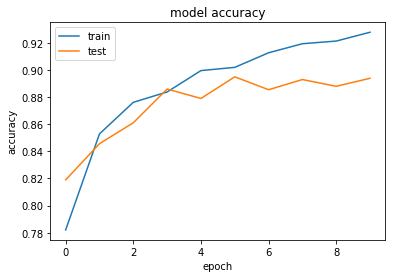

In [69]:
plt.plot(fitted_model.history['acc'])
plt.plot(fitted_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

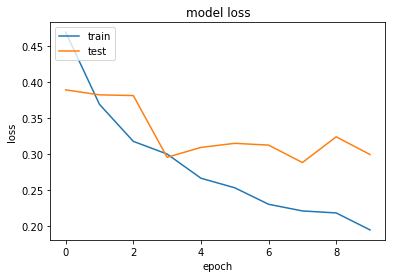

In [70]:
plt.figure()
plt.gcf().clear()
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()